In [12]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import kagglehub
from concurrent.futures import ThreadPoolExecutor
import random

Loading the dataset

In [13]:
path = kagglehub.dataset_download("yasserhessein/gender-dataset")

100%|██████████| 1.32G/1.32G [00:13<00:00, 104MB/s]

Extracting files...


In [14]:

dataset_dir = path + "/Dataset"
image_size = (64, 64)
batch_size = 32
train_size = 16384
val_size = 4096
test_size = 4096

In [15]:
import cv2
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_faces(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    if len(faces) == 0:
        return []

    return faces

Processing Image

In [16]:
def process_image(image_path, image_size, face_detection=True):
    image = cv2.imread(image_path)

    if face_detection:
        faces = detect_faces(image)
        if len(faces) == 0:
            return None

        for (x, y, w, h) in faces:
            cropped_face = image[y:y+h, x:x+w]
            cropped_face_resized = cv2.resize(cropped_face, image_size)
            return cropped_face_resized / 255.0

    else:
        image_resized = cv2.resize(image, image_size)
        return image_resized / 255.0

Spliting The dataset

In [17]:
def preprocess_and_split_dataset(directory, image_size, train_size, val_size, test_size, face_detection=True, progress_interval=50):
    processed_images = []
    labels = []
    label_map = {'Male': 1, 'Female': 0}

    random.seed(42)
    all_image_paths = []
    all_labels = []

    for label, class_label in label_map.items():
        class_dir = f"{directory}/{label}"
        image_paths = list(tf.io.gfile.glob(f"{class_dir}/*"))
        random.shuffle(image_paths)
        all_image_paths.extend(image_paths)
        all_labels.extend([class_label] * len(image_paths))

    combined = list(zip(all_image_paths, all_labels))
    random.shuffle(combined)
    all_image_paths, all_labels = zip(*combined)

    for idx, (image_path, label) in enumerate(zip(all_image_paths, all_labels)):
        if len(processed_images) >= (train_size + val_size + test_size):
            break

        image = cv2.imread(image_path)
        if face_detection:
            faces = detect_faces(image)
            for (x, y, w, h) in faces:
                cropped_face = image[y:y+h, x:x+w]
                cropped_face_resized = cv2.resize(cropped_face, image_size)
                processed_images.append(cropped_face_resized / 255.0)
                labels.append(label)
                if len(processed_images) >= (train_size + val_size + test_size):
                    break
        else:
            resized_image = cv2.resize(image, image_size)
            processed_images.append(resized_image / 255.0)
            labels.append(label)

        if (len(processed_images)) % progress_interval == 0:
            print(f"Processed {len(processed_images)} images...")

    processed_images = np.array(processed_images)
    labels = np.array(labels)

    np.random.seed(42)
    indices = np.arange(len(processed_images))
    np.random.shuffle(indices)
    processed_images = processed_images[indices]
    labels = labels[indices]

    train_images = processed_images[:train_size]
    train_labels = labels[:train_size]
    val_images = processed_images[train_size:train_size + val_size]
    val_labels = labels[train_size:train_size + val_size]
    test_images = processed_images[train_size + val_size:train_size + val_size + test_size]
    test_labels = labels[train_size + val_size:train_size + val_size + test_size]

    print(f"Dataset split complete. Train: {len(train_images)}, Val: {len(val_images)}, Test: {len(test_images)}")

    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

Training The Dataset

In [18]:
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = preprocess_and_split_dataset(
    f"{dataset_dir}/Train", image_size, train_size, val_size, test_size, face_detection=True)

Processed 0 images...
Processed 50 images...
Processed 100 images...
Processed 150 images...
Processed 200 images...
Processed 250 images...
Processed 300 images...
Processed 350 images...
Processed 400 images...
Processed 450 images...
Processed 500 images...
Processed 550 images...
Processed 600 images...
Processed 650 images...
Processed 700 images...
Processed 750 images...
Processed 800 images...
Processed 850 images...
Processed 900 images...
Processed 950 images...
Processed 1000 images...
Processed 1050 images...
Processed 1100 images...
Processed 1150 images...
Processed 1200 images...
Processed 1250 images...
Processed 1300 images...
Processed 1400 images...
Processed 1450 images...
Processed 1500 images...
Processed 1550 images...
Processed 1600 images...
Processed 1650 images...
Processed 1700 images...
Processed 1750 images...
Processed 1800 images...
Processed 1850 images...
Processed 1900 images...
Processed 1950 images...
Processed 2000 images...
Processed 2050 images..

In [19]:
from tensorflow.keras import layers, models
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=10)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 95s 181ms/step - accuracy: 0.7552 - loss: 0.4788 - val_accuracy: 0.9084 - val_loss: 0.2112
Epoch 2/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 142s 181ms/step - accuracy: 0.9073 - loss: 0.2311 - val_accuracy: 0.9243 - val_loss: 0.1790
Epoch 3/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 148s 192ms/step - accuracy: 0.9277 - loss: 0.1836 - val_accuracy: 0.9336 - val_loss: 0.1522
Epoch 4/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 135s 178ms/step - accuracy: 0.9364 - loss: 0.1556 - val_accuracy: 0.9353 - val_loss: 0.1560
Epoch 5/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 144s 182ms/step - accuracy: 0.9449 - loss: 0.1351 - val_accuracy: 0.9365 - val_loss: 0.1499
Epoch 6/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 94s 183ms/step - accuracy: 0.9446 - loss: 0.1286 - val_accuracy: 0.9426 - val_loss: 0.1515
Epoch 7/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 141s 182ms/step - accuracy: 0.9538 - loss: 0.1131 - val_accuracy: 0.9395 - val_loss: 0.1383
Epoch 8/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 140s 179ms/step - accuracy: 0.9569 - l

Building The Model

In [20]:
model.save("gender_classification_model.keras")

# Load the model
model = tf.keras.models.load_model("gender_classification_model.keras")

In [21]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc*100}%")

128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9440 - loss: 0.1599
Test accuracy: 94.2138671875%


Defing a function to predict the gender

In [22]:
def predict_gender_from_image(image, model):
    faces = detect_faces(image)

    if len(faces) == 0:
        return None

    for (x, y, w, h) in faces:
        cropped_face = image[y:y+h, x:x+w]
        cropped_face_resized = cv2.resize(cropped_face, (64, 64))
        cropped_face_resized = cropped_face_resized / 255.0

        cropped_face_resized = np.expand_dims(cropped_face_resized, axis=0)
        prediction = model.predict(cropped_face_resized)

        label = np.argmax(prediction, axis=1)
        gender = 'Male' if label == 1 else 'Female'
        confidence = float(prediction[0][label] * 100)

        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, f"{gender} - {confidence:.2f}%", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)

    return image


In [23]:
from google.colab.patches import cv2_imshow


In [24]:
def process_input(input_type, image_path=None, model=None):
    if input_type == 'image':
        if image_path is None:
            print("Error: Image path is required for image input.")
            return

        image = cv2.imread(image_path)
        output_image = predict_gender_from_image(image, model)
        if output_image is not None:
            cv2_imshow(output_image)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
        else:
            print("No faces detected.")

    elif input_type == 'webcam':
        cap = cv2.VideoCapture(0)
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            output_image = predict_gender_from_image(frame, model)
            if output_image is not None:
                cv2_imshow(output_image)
            else:
                print("No faces detected.")

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()

In [25]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='live.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

Importing the dataset from the Google Drive

In [42]:
from google.colab import drive


# Mount Google Drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


Live detection of gender from the Web Camera

<IPython.core.display.Javascript object>

Saved to live.jpg


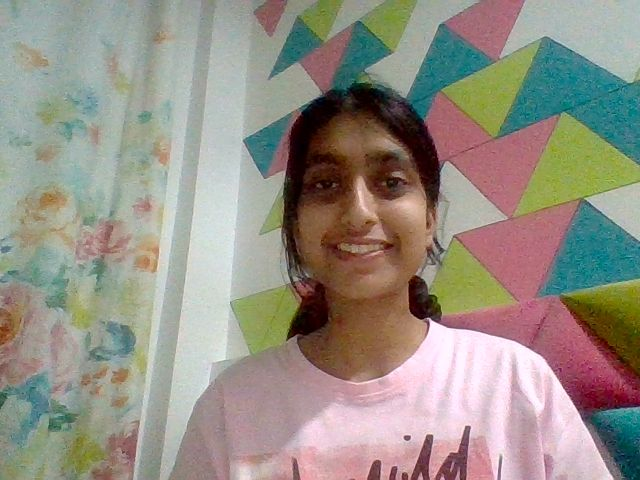

In [68]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<ipython-input-22-a8d0fa5db364>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0][label] * 100)


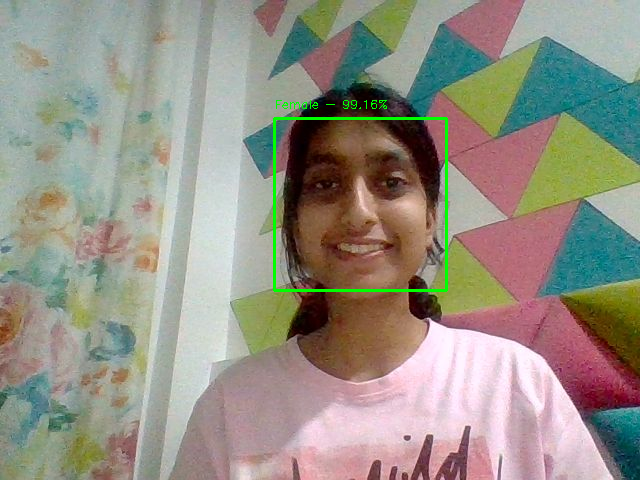

In [69]:
image_path = 'live.jpg'
process_input('image', image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


<ipython-input-22-a8d0fa5db364>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0][label] * 100)


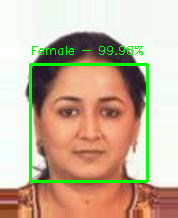

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


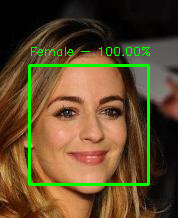

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


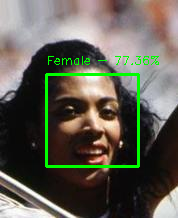

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


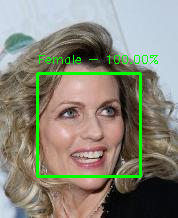

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


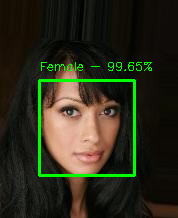

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


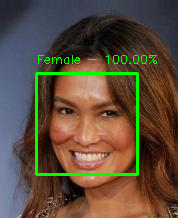

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


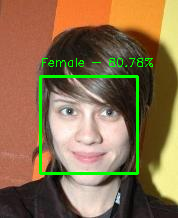

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


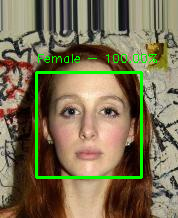

In [70]:
for i in range (2,10):
  image_path=f'/content/drive/MyDrive/Dataset/test/female/{i}.jpg'
  process_input('image', image_path, model)


#except cv2.error as e:
    #print(f"Error processing image {image_path}: {e}")
    #continue  #Skip to next image if error occurs



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


<ipython-input-22-a8d0fa5db364>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0][label] * 100)


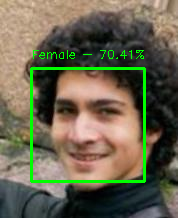

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


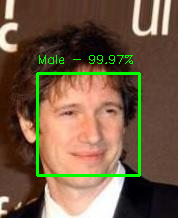

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


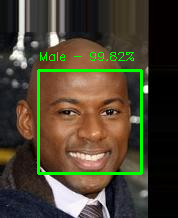

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


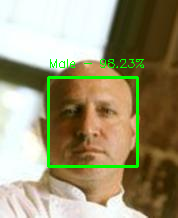

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


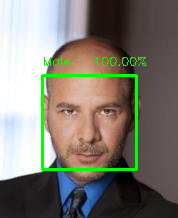

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


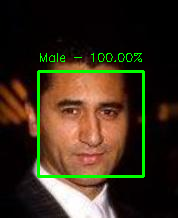

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


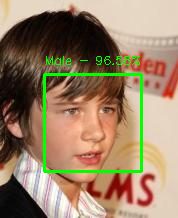

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


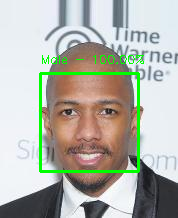

In [60]:
for i in range (2,10):
  image_path=f'/content/drive/MyDrive/Dataset/test/male/{i}.jpg'
  process_input('image', image_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


<ipython-input-22-a8d0fa5db364>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0][label] * 100)


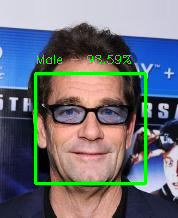

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


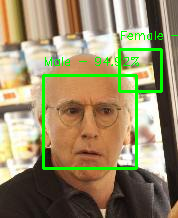

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


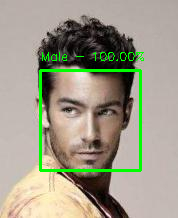

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


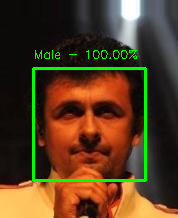

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


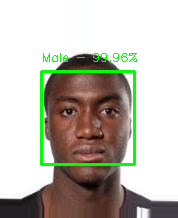

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


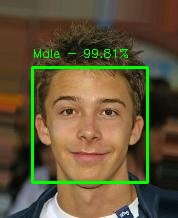

In [71]:
for i in range (11,17):
  image_path=f'/content/drive/MyDrive/Dataset/test/male/{i}.jpg'
  process_input('image', image_path, model)
